In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from smatrix_optim.data_loader.empad_loader import EMPADLoader
from smatrix_optim.data_loader.abtem_yaml_loader import  AbTEMLoader
from smatrix_optim.data_loader.smatrix_calc_cbed_loader import SmatrixCalcCBEDLoader
from smatrix_optim.data_loader.abtem_zarr_loader import AbTEMZarrLoader
from Pixel_class import Pixelated_STEM

In [2]:
path_empad = '/mnt/d/ExperimentalData_MCEM/20240521_STO/20240521_Kousuke/1453_20.7mrad_58Mx_360mm/params.yaml'
path_abtem = "/home/kousuke/abtem_env/workspace/private/STO/300kV20mrad_3x3SuperCell/th195A_df-100A.yaml"
path_smatrix = "/home/kousuke/abtem_env/workspace/private/STO/SMatrix_simulated/SrTiO3_001_kirkland_3x3_300kV_20mrad_th195A_df-100A_kirkland.hdf5"
path_abtem_zarr = "/home/kousuke/abtem_env/workspace/private/STO/300kV20mrad_6x6SuperCell/th400A_df-200A.yaml"

In [3]:
os.path.dirname("/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test.yaml")+"/"\
+ os.path.basename("/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test.yaml").split(".")[0]

'/mnt/g/My Drive/Python/my_libs/smatrix_optim/params_optimisation_test'

In [4]:
config_optim = {
"config_path": path_abtem_zarr,
"data_type": "abtem_zarr",
"binning_diff": 1,
"thickness_init": 200,
"defocus_init": -100,
}

In [5]:
if config_optim['data_type'] == "empad":
    data_loader = EMPADLoader(config_optim['config_path'])
elif config_optim['data_type'] == "smatrix_calc_cbed":
    data_loader = SmatrixCalcCBEDLoader(config_optim['config_path'])
elif config_optim['data_type'] == "abtem":
    data_loader = AbTEMLoader(config_optim['config_path'])
elif config_optim['data_type'] == "abtem_zarr":
    data_loader = AbTEMZarrLoader(config_optim['config_path'])
else:
    raise ValueError("Invalid data type specified in the configuration.")

In [6]:
# Load the data
data_loader.load_data()
cbed = data_loader.raw_params['data']
cbed = data_loader.binning_diff(cbed, config_optim['binning_diff'])

data_loader.raw_params['sampling_diff'] *= config_optim['binning_diff']
print(f"Sampling difference after binning: {data_loader.raw_params['sampling_diff']}")

Sampling difference after binning: [0.042646469298806756, 0.042646469298806756]


In [7]:
data_loader.raw_params['sampling_scan']

[0.21711666666666665, 0.21711666666666665]

In [8]:
pixel = Pixelated_STEM(
    voltage =data_loader.raw_params['voltage'],
    aperture=data_loader.raw_params['aperture'],
)
pixel.load_parameter(
    thickness=config_optim['thickness_init'],
    defocus  =config_optim['defocus_init'],
    dry=data_loader.raw_params['sampling_scan'][0],
    drx=data_loader.raw_params['sampling_scan'][1],
    dkx=data_loader.raw_params['sampling_diff'][0]*config_optim['binning_diff'],
    dky=data_loader.raw_params['sampling_diff'][1]*config_optim['binning_diff'],
    rot_offset_rad=data_loader.raw_params['rot_offset_deg']*np.pi/180,
)
pixel.cbed_import(cbed/np.sum(cbed, axis=(2,3))[:,:,np.newaxis,np.newaxis])
print(data_loader.raw_params)

obf_from_measured_cbed = pixel.OBF_pixel()

4D data imported!
{'data': array([[[[1.06530624e-08, 2.85220551e-07, 4.97716599e-07, ...,
          5.36552704e-07, 5.70661882e-07, 3.10878363e-07],
         [2.96516873e-07, 5.78414415e-07, 5.15879094e-07, ...,
          5.64351637e-07, 5.45461717e-07, 6.27436975e-07],
         [5.04124841e-07, 5.10669679e-07, 8.35547269e-07, ...,
          7.81444101e-07, 6.43194937e-07, 6.07972027e-07],
         ...,
         [5.77758556e-07, 5.85752105e-07, 7.59955867e-07, ...,
          9.49766445e-07, 7.85988107e-07, 6.68090991e-07],
         [4.41718868e-07, 5.18560739e-07, 6.40314454e-07, ...,
          7.25426958e-07, 7.19720788e-07, 6.33540594e-07],
         [2.24828767e-07, 4.87270370e-07, 5.51166181e-07, ...,
          6.22179186e-07, 5.94204948e-07, 5.56988937e-07]],

        [[8.71866757e-09, 3.37878021e-07, 5.37618007e-07, ...,
          4.05989852e-07, 5.30809132e-07, 2.56980542e-07],
         [3.41631420e-07, 6.79773791e-07, 6.11152814e-07, ...,
          5.91934167e-07, 4.90552566e-07

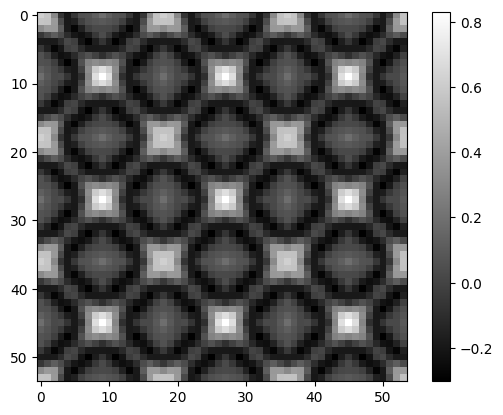

In [9]:
plt.imshow(np.tile(obf_from_measured_cbed, (3,3)), cmap='gray')
plt.colorbar()